# TUGAS EKSPLORASI: PERBANDINGAN MODEL VISION TRANSFORMER
## DeiT-Tiny vs Swin-Tiny

Nama : Alfajar <br>
NIM : 122140122

## Import Libarary

In [35]:
import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from timm import create_model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

Device: cuda


## Configuration

In [36]:
BASE_DIR = "/kaggle/input/chest-ctscan-images/Data"

train_dir = os.path.join(BASE_DIR, "train")
valid_dir = os.path.join(BASE_DIR, "valid")
test_dir  = os.path.join(BASE_DIR, "test")

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30
LR = 3e-4
NUM_WORKERS = 2

print(train_dir)

/kaggle/input/chest-ctscan-images/Data/train


## Data Loader

In [37]:
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

train_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
])

test_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
])


train_ds = datasets.ImageFolder(train_dir, transform=train_tf)
valid_ds = datasets.ImageFolder(valid_dir, transform=test_tf)
test_ds  = datasets.ImageFolder(test_dir,  transform=test_tf)

g = torch.Generator()
g.manual_seed(SEED)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    worker_init_fn=seed_worker,
    generator=g,
)

valid_loader = DataLoader(
    valid_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    worker_init_fn=seed_worker,
    generator=g,
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    worker_init_fn=seed_worker,
    generator=g,
)

class_names = train_ds.classes
num_classes = len(class_names)

print("Jumlah kelas:", num_classes)
print("Kelas:", class_names)
print("Jumlah data train:", len(train_ds))
print("Jumlah data valid:", len(valid_ds))
print("Jumlah data test:", len(test_ds))

Jumlah kelas: 4
Kelas: ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']
Jumlah data train: 613
Jumlah data valid: 72
Jumlah data test: 315


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


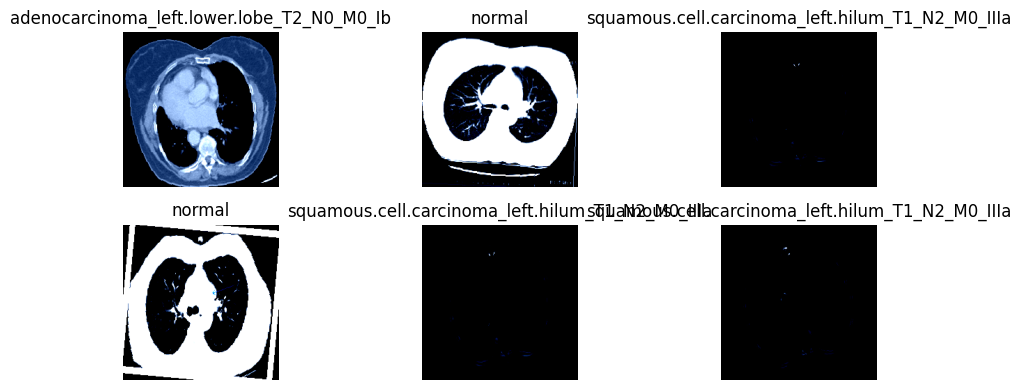

In [38]:
images, labels = next(iter(train_loader))

plt.figure(figsize=(10, 4))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.tight_layout()
plt.show()

## Training Pipeline

In [39]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        running_loss += loss.item()
        preds = outputs.argmax(1)
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())

    avg_loss = running_loss / len(loader)
    acc = accuracy_score(all_labels, all_preds)

    return avg_loss, acc, np.array(all_labels), np.array(all_preds)


def eval_one_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            preds = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(loader)
    acc = accuracy_score(all_labels, all_preds)

    return avg_loss, acc, np.array(all_labels), np.array(all_preds)


def train_model(model, train_loader, valid_loader, epochs=30, lr=3e-5):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=lr,
        weight_decay=0.01,
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="min",
        factor=0.5,
        patience=3,
        verbose=True,
    )

    history = {
        "train_loss": [],
        "valid_loss": [],
        "train_acc": [],
        "valid_acc": [],
    }

    best_val_loss = float("inf")
    best_state = None
    best_epoch = 0

    for ep in range(epochs):
        train_loss, train_acc, _, _ = train_one_epoch(model, train_loader, criterion, optimizer)
        valid_loss, valid_acc, _, _ = eval_one_epoch(model, valid_loader, criterion)

        history["train_loss"].append(train_loss)
        history["valid_loss"].append(valid_loss)
        history["train_acc"].append(train_acc)
        history["valid_acc"].append(valid_acc)

        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            best_state = model.state_dict().copy()
            best_epoch = ep + 1

        scheduler.step(valid_loss)

        print(
            f"Epoch {ep+1}/{epochs} "
            f"- Train Loss: {train_loss:.4f} "
            f"- Valid Loss: {valid_loss:.4f} "
            f"- Train Acc: {train_acc:.4f} "
            f"- Valid Acc: {valid_acc:.4f}"
        )

    print(f"\nBest epoch: {best_epoch} | Best val loss: {best_val_loss:.4f}")
    if best_state is not None:
        model.load_state_dict(best_state)

    return history



## Model Evaluation Pipeline

In [57]:
def evaluate_full(model, loader, model_name="Model"):
    criterion = nn.CrossEntropyLoss()

    # hitung loss dan akurasi + ambil prediksi
    val_loss, val_acc, y_true, y_pred = eval_one_epoch(model, loader, criterion)

    # classification report
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )

    print(f"=== {model_name} - Test Results ===")
    print(f"Loss: {val_loss:.4f}")
    print(f"Accuracy: {val_acc:.4f}")
    print(f"Precision (macro): {prec:.4f}")
    print(f"Recall (macro): {rec:.4f}")
    print(f"F1 (macro): {f1:.4f}")
    print()
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Prediction")
    ax.set_ylabel("Actual")
    tick_marks = np.arange(len(class_names))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    cbar = ax.figure.colorbar(im, ax=ax)

    for i in range(len(cm)):
        for j in range(len(cm[i])):
            ax.text(
                j, i, cm[i][j],
                ha="center", va="center",
                color="black",
                fontsize=11
            )

    plt.tight_layout()
    plt.show()


    # ukur waktu inferensi per gambar
    model.eval()
    n_images = 0
    start = time.time()

    with torch.no_grad():
        # warm up 1 batch
        for imgs, _ in loader:
            imgs = imgs.to(device)
            _ = model(imgs)
            break

        start = time.time()
        for imgs, _ in loader:
            imgs = imgs.to(device)
            _ = model(imgs)
            n_images += imgs.size(0)
    end = time.time()

    total_time = end - start
    time_per_image = total_time / n_images
    throughput = n_images / total_time

    print(f"Waktu inferensi total: {total_time:.4f} detik untuk {n_images} gambar")
    print(f"Waktu rata-rata per gambar: {time_per_image*1000:.4f} ms")
    print(f"Throughput: {throughput:.2f} gambar/detik")

    metrics = {
        "loss": val_loss,
        "acc": val_acc,
        "precision_macro": prec,
        "recall_macro": rec,
        "f1_macro": f1,
        "time_total": total_time,
        "time_per_image_ms": time_per_image * 1000,
        "throughput_img_per_s": throughput,
    }

    return metrics

## Parameter Counting and Model Size Estimation

In [41]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable = total - trainable
    return total, trainable, non_trainable

def print_param_info(model, name="Model"):
    total, trainable, non_trainable = count_parameters(model)
    print(f"{name} - Total params: {total:,}")
    print(f"{name} - Trainable: {trainable:,}")
    print(f"{name} - Non-trainable: {non_trainable:,}")
    print(f"{name} - Approx size: {total * 4 / (1024**2):.2f} MB (float32)")

## Model Initialization (ViT-Tiny) + Training Execution Pipeline

In [42]:
model_vit = create_model(
    "vit_tiny_patch16_224",
    pretrained=True,
    num_classes=num_classes,
)
model_vit.to(device)

print_param_info(model_vit, "ViT-tiny")

history_vit = train_model(
    model_vit,
    train_loader,
    valid_loader,
    epochs=EPOCHS,
    lr=LR,
)

ViT-tiny - Total params: 5,525,188
ViT-tiny - Trainable: 5,525,188
ViT-tiny - Non-trainable: 0
ViT-tiny - Approx size: 21.08 MB (float32)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30 - Train Loss: 1.3037 - Valid Loss: 1.3794 - Train Acc: 0.4796 - Valid Acc: 0.4861
Epoch 2/30 - Train Loss: 1.0242 - Valid Loss: 1.1641 - Train Acc: 0.5563 - Valid Acc: 0.3750
Epoch 3/30 - Train Loss: 0.9618 - Valid Loss: 1.5582 - Train Acc: 0.5971 - Valid Acc: 0.4861
Epoch 4/30 - Train Loss: 1.0046 - Valid Loss: 1.2318 - Train Acc: 0.5873 - Valid Acc: 0.4167
Epoch 5/30 - Train Loss: 0.8529 - Valid Loss: 0.9350 - Train Acc: 0.6346 - Valid Acc: 0.6111
Epoch 6/30 - Train Loss: 0.7982 - Valid Loss: 1.0990 - Train Acc: 0.7227 - Valid Acc: 0.5139
Epoch 7/30 - Train Loss: 0.7018 - Valid Loss: 1.4291 - Train Acc: 0.7569 - Valid Acc: 0.5694
Epoch 8/30 - Train Loss: 1.0058 - Valid Loss: 1.0582 - Train Acc: 0.6330 - Valid Acc: 0.5139
Epoch 9/30 - Train Loss: 0.7341 - Valid Loss: 1.3959 - Train Acc: 0.7716 - Valid Acc: 0.4306
Epoch 10/30 - Train Loss: 0.6869 - Valid Loss: 0.9772 - Train Acc: 0.7684 - Valid Acc: 0.6111
Epoch 11/30 - Train Loss: 0.5463 - Valid Loss: 0.7540 - Train Acc: 0.

=== ViT-tiny - Test Results ===
Loss: 0.5731
Accuracy: 0.8063
Precision (macro): 0.8202
Recall (macro): 0.8405
F1 (macro): 0.8206

Classification Report:
                                                  precision    recall  f1-score   support

      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib       0.83      0.71      0.76       120
   large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa       0.59      0.90      0.71        51
                                          normal       1.00      0.96      0.98        54
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa       0.87      0.79      0.83        90

                                        accuracy                           0.81       315
                                       macro avg       0.82      0.84      0.82       315
                                    weighted avg       0.83      0.81      0.81       315



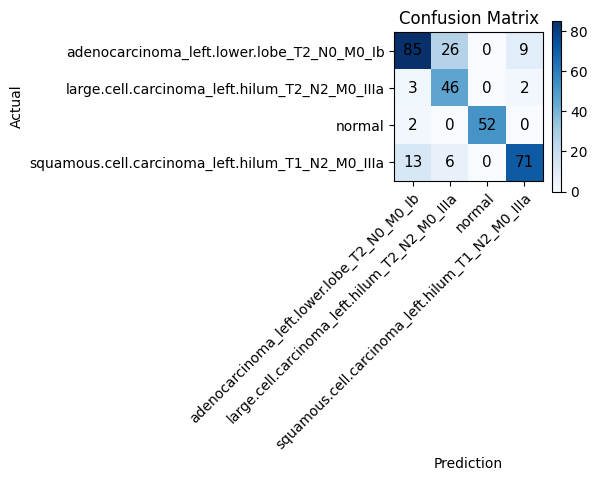

Waktu inferensi total: 1.5571 detik untuk 315 gambar
Waktu rata-rata per gambar: 4.9433 ms
Throughput: 202.30 gambar/detik


{'loss': 0.5731373012065888,
 'acc': 0.8063492063492064,
 'precision_macro': 0.8202099916816942,
 'recall_macro': 0.8405364923747276,
 'f1_macro': 0.8205559009898004,
 'time_total': 1.5571305751800537,
 'time_per_image_ms': 4.943271667238266,
 'throughput_img_per_s': 202.29517358464045}

In [58]:
metrics_vit = evaluate_full(model_vit, test_loader, model_name="ViT-tiny")
metrics_vit

## Model Initialization (DeiT-Tiny Distill) + Training Execution Pipeline

In [44]:
model_deit = create_model(
    "deit_tiny_distilled_patch16_224",
    pretrained=True,
    num_classes=num_classes,
)
model_deit.to(device)

print_param_info(model_deit, "DeiT-tiny")

history_deit = train_model(
    model_deit,
    train_loader,
    valid_loader,
    epochs=EPOCHS,
    lr=LR,
)

DeiT-tiny - Total params: 5,526,344
DeiT-tiny - Trainable: 5,526,344
DeiT-tiny - Non-trainable: 0
DeiT-tiny - Approx size: 21.08 MB (float32)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30 - Train Loss: 1.0768 - Valid Loss: 1.3736 - Train Acc: 0.5498 - Valid Acc: 0.4722
Epoch 2/30 - Train Loss: 0.9332 - Valid Loss: 1.1244 - Train Acc: 0.6069 - Valid Acc: 0.5417
Epoch 3/30 - Train Loss: 0.8594 - Valid Loss: 1.2158 - Train Acc: 0.6542 - Valid Acc: 0.4722
Epoch 4/30 - Train Loss: 0.8304 - Valid Loss: 1.0300 - Train Acc: 0.6770 - Valid Acc: 0.5556
Epoch 5/30 - Train Loss: 0.7863 - Valid Loss: 1.2044 - Train Acc: 0.6835 - Valid Acc: 0.5278
Epoch 6/30 - Train Loss: 0.6785 - Valid Loss: 1.2226 - Train Acc: 0.7602 - Valid Acc: 0.4861
Epoch 7/30 - Train Loss: 0.5604 - Valid Loss: 1.1676 - Train Acc: 0.8222 - Valid Acc: 0.6111
Epoch 8/30 - Train Loss: 0.5525 - Valid Loss: 1.1076 - Train Acc: 0.8140 - Valid Acc: 0.6806
Epoch 9/30 - Train Loss: 0.4516 - Valid Loss: 1.2247 - Train Acc: 0.8744 - Valid Acc: 0.6250
Epoch 10/30 - Train Loss: 0.4781 - Valid Loss: 0.7648 - Train Acc: 0.8662 - Valid Acc: 0.7778
Epoch 11/30 - Train Loss: 0.3517 - Valid Loss: 0.9592 - Train Acc: 0.

=== DeiT-tiny - Test Results ===
Loss: 0.4753
Accuracy: 0.8476
Precision (macro): 0.8714
Recall (macro): 0.8699
F1 (macro): 0.8596

Classification Report:
                                                  precision    recall  f1-score   support

      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib       0.79      0.89      0.84       120
   large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa       0.76      0.98      0.85        51
                                          normal       1.00      0.96      0.98        54
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa       0.94      0.64      0.76        90

                                        accuracy                           0.85       315
                                       macro avg       0.87      0.87      0.86       315
                                    weighted avg       0.86      0.85      0.84       315



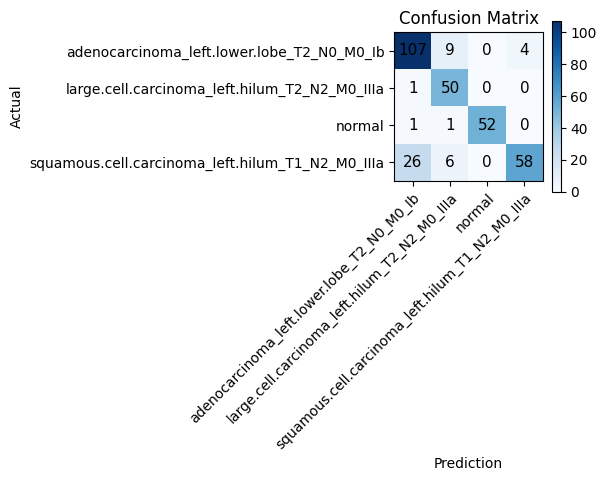

Waktu inferensi total: 1.5776 detik untuk 315 gambar
Waktu rata-rata per gambar: 5.0083 ms
Throughput: 199.67 gambar/detik


{'loss': 0.47530234307050706,
 'acc': 0.8476190476190476,
 'precision_macro': 0.871413055284023,
 'recall_macro': 0.8698665577342047,
 'f1_macro': 0.8595516277959762,
 'time_total': 1.5776300430297852,
 'time_per_image_ms': 5.008349342951699,
 'throughput_img_per_s': 199.66658304443362}

In [59]:
metrics_deit = evaluate_full(model_deit, test_loader, model_name="DeiT-tiny")
metrics_deit

## Model Initialization (Swin-Tiny) + Training Execution Pipeline

In [46]:
model_swin = create_model(
    "swin_tiny_patch4_window7_224",
    pretrained=True,
    num_classes=num_classes,
)
model_swin.to(device)

print_param_info(model_swin, "Swin-tiny")

history_swin = train_model(
    model_swin,
    train_loader,
    valid_loader,
    epochs=EPOCHS,
    lr=LR,
)

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Swin-tiny - Total params: 27,522,430
Swin-tiny - Trainable: 27,522,430
Swin-tiny - Non-trainable: 0
Swin-tiny - Approx size: 104.99 MB (float32)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30 - Train Loss: 1.1379 - Valid Loss: 1.0729 - Train Acc: 0.4878 - Valid Acc: 0.4861
Epoch 2/30 - Train Loss: 0.9613 - Valid Loss: 1.0128 - Train Acc: 0.5808 - Valid Acc: 0.4861
Epoch 3/30 - Train Loss: 0.9038 - Valid Loss: 1.1199 - Train Acc: 0.5971 - Valid Acc: 0.4444
Epoch 4/30 - Train Loss: 0.8652 - Valid Loss: 1.1715 - Train Acc: 0.6232 - Valid Acc: 0.4722
Epoch 5/30 - Train Loss: 0.7561 - Valid Loss: 1.1524 - Train Acc: 0.7227 - Valid Acc: 0.5278
Epoch 6/30 - Train Loss: 0.7265 - Valid Loss: 1.0631 - Train Acc: 0.7439 - Valid Acc: 0.5972
Epoch 7/30 - Train Loss: 0.5850 - Valid Loss: 0.9187 - Train Acc: 0.8010 - Valid Acc: 0.6389
Epoch 8/30 - Train Loss: 0.5086 - Valid Loss: 0.9827 - Train Acc: 0.8515 - Valid Acc: 0.6806
Epoch 9/30 - Train Loss: 0.4731 - Valid Loss: 1.1654 - Train Acc: 0.8825 - Valid Acc: 0.5694
Epoch 10/30 - Train Loss: 0.4377 - Valid Loss: 0.8028 - Train Acc: 0.9021 - Valid Acc: 0.7639
Epoch 11/30 - Train Loss: 0.4019 - Valid Loss: 0.9186 - Train Acc: 0.

=== Swin-tiny - Test Results ===
Loss: 0.6248
Accuracy: 0.8254
Precision (macro): 0.8546
Recall (macro): 0.8690
F1 (macro): 0.8388

Classification Report:
                                                  precision    recall  f1-score   support

      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib       0.90      0.72      0.80       120
   large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa       0.54      1.00      0.70        51
                                          normal       1.00      0.98      0.99        54
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa       0.99      0.78      0.87        90

                                        accuracy                           0.83       315
                                       macro avg       0.85      0.87      0.84       315
                                    weighted avg       0.88      0.83      0.83       315



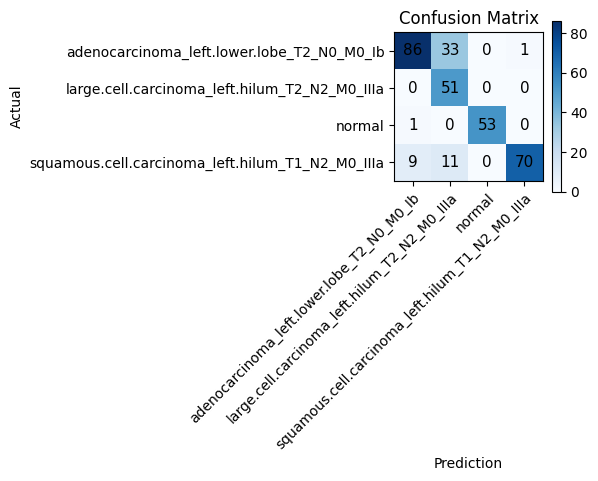

Waktu inferensi total: 1.7197 detik untuk 315 gambar
Waktu rata-rata per gambar: 5.4593 ms
Throughput: 183.17 gambar/detik


{'loss': 0.6248336378484964,
 'acc': 0.8253968253968254,
 'precision_macro': 0.8546477328885594,
 'recall_macro': 0.8689814814814815,
 'f1_macro': 0.8387864640703449,
 'time_total': 1.7196850776672363,
 'time_per_image_ms': 5.459317706880115,
 'throughput_img_per_s': 183.1730728438369}

In [60]:
metrics_swin = evaluate_full(model_swin, test_loader, model_name="Swin-tiny")
metrics_swin

## Learning Curve

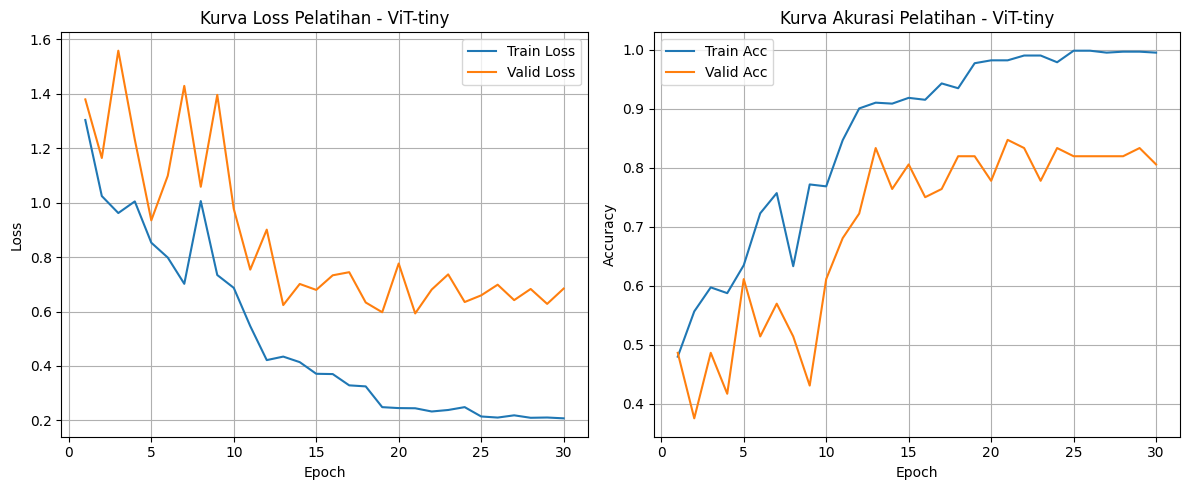

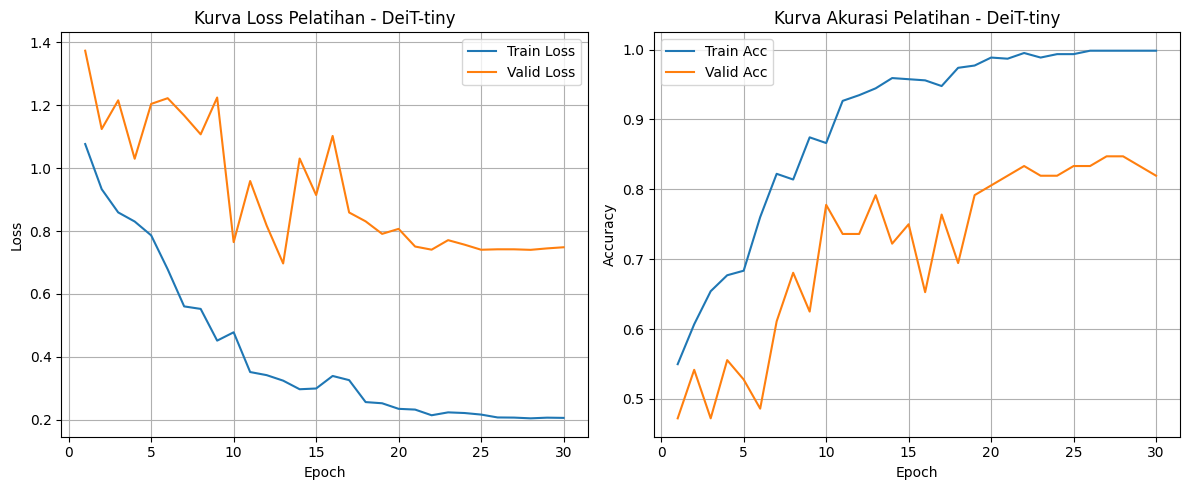

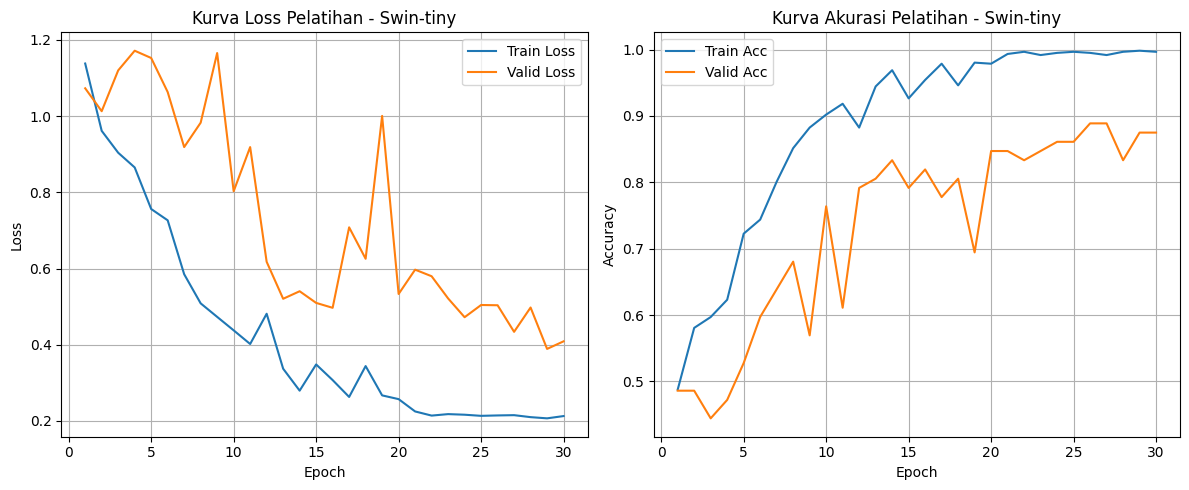

In [56]:
def plot_history(history, model_name):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["valid_loss"], label="Valid Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Kurva Loss Pelatihan - {model_name}")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["valid_acc"], label="Valid Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Kurva Akurasi Pelatihan - {model_name}")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


plot_history(history_vit, "ViT-tiny")
plot_history(history_deit, "DeiT-tiny")
plot_history(history_swin, "Swin-tiny")


## Comparation

In [50]:
compare_df = pd.DataFrame({
    "Model": ["DeiT-tiny", "Swin-tiny", "ViT-tiny"],
    "Acc": [metrics_vit["acc"], metrics_deit["acc"], metrics_swin["acc"]],
    "Precision_macro": [metrics_vit["precision_macro"], metrics_deit["precision_macro"], metrics_swin["precision_macro"]],
    "Recall_macro": [metrics_vit["recall_macro"], metrics_deit["recall_macro"], metrics_swin["recall_macro"]],
    "F1_macro": [metrics_vit["f1_macro"], metrics_deit["f1_macro"], metrics_swin["f1_macro"]],
    "Time_total_test(s)": [metrics_vit["time_total"], metrics_deit["time_total"], metrics_swin["time_total"]],
    "Time_per_image(ms)": [metrics_vit["time_per_image_ms"], metrics_deit["time_per_image_ms"], metrics_swin["time_per_image_ms"]],
    "Throughput(img/s)": [metrics_vit["throughput_img_per_s"], metrics_deit["throughput_img_per_s"], metrics_swin["throughput_img_per_s"]],
})

compare_df

,Model,Acc,Precision_macro,Recall_macro,F1_macro,Time_total_test(s),Time_per_image(ms),Throughput(img/s)
0,DeiT-tiny,0.806349,0.820210,0.840536,0.820556,1.490049,4.730314,211.402460
1,Swin-tiny,0.847619,0.871413,0.869867,0.859552,1.522382,4.832959,206.912585
2,ViT-tiny,0.825397,0.854648,0.868981,0.838786,1.691068,5.368471,186.272772


## Save Model

In [51]:
compare_df.to_csv("comparison_deit_swin.csv", index=False)
torch.save(model_deit.state_dict(), "vit_tiny.pth")
torch.save(model_deit.state_dict(), "deit_tiny.pth")
torch.save(model_swin.state_dict(), "swin_tiny.pth")
print("File disimpan.")

File disimpan.
